<a href="https://colab.research.google.com/github/DaH7/Machine-Learning-Concepts/blob/main/custom_datasets_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. import pytorch and settting up device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##1. Getting custom data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
import os
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [6]:
#setup train and test paths
train_dir = image_path/ "train"
test_dir  = image_path/ "test"


In [7]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

###2.1 Visualize an image





Random image path: data/pizza_steak_sushi/train/steak/1382427.jpg
Image class: steak
Image height: 512
Image width: 512


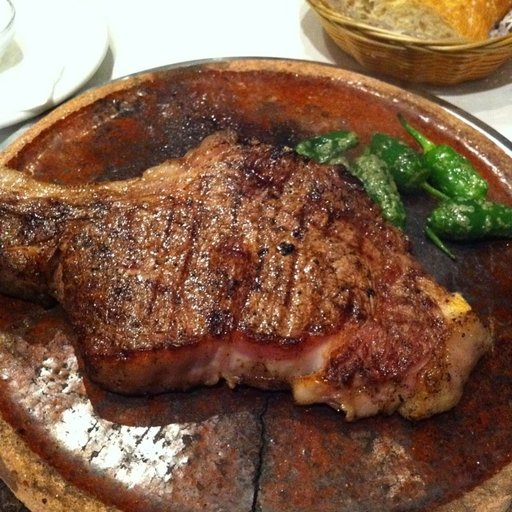

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


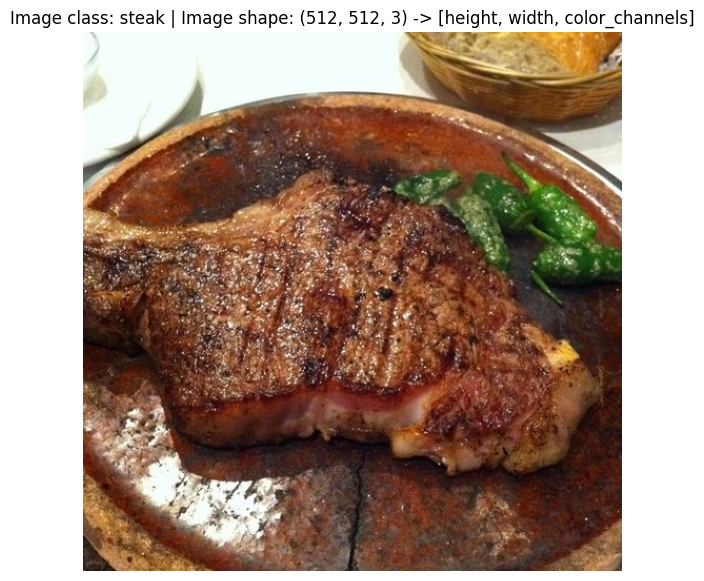

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# turn image into array
img_as_array = np.asarray(img)

#plot image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

(-0.5, 511.5, 511.5, -0.5)

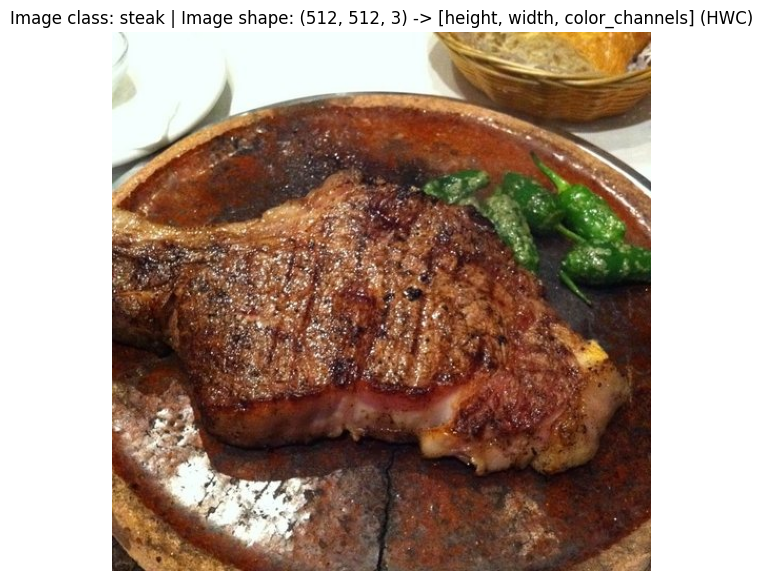

In [10]:
#using matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)


## 3. Transforming data

1.   Turn it into tensors (numerical representations of our images).
2.   Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, these are called `Dataset` and `DataLoader` for short.
3.   Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
4.   Flip images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
5.   Turn images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`




In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [12]:
#Write transform for image
data_transform = transforms.Compose([
  #resize image to 64x64
  transforms.Resize(size=(64,64)),
  #flip image horizontal
  transforms.RandomHorizontalFlip(p=0.5), #50 percent chance image gets flip
  #turn image to torch.Tensor
  transforms.ToTensor() #convert all pixel values from 0 to 255 to btw 0.0 and 1.0
])

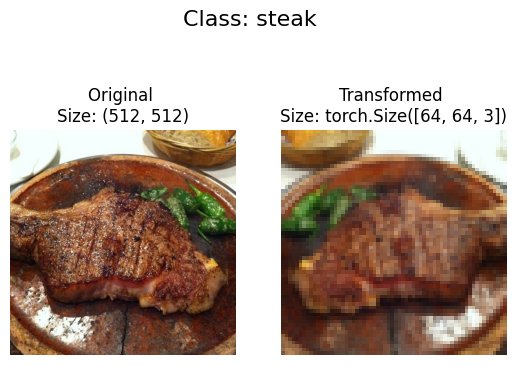

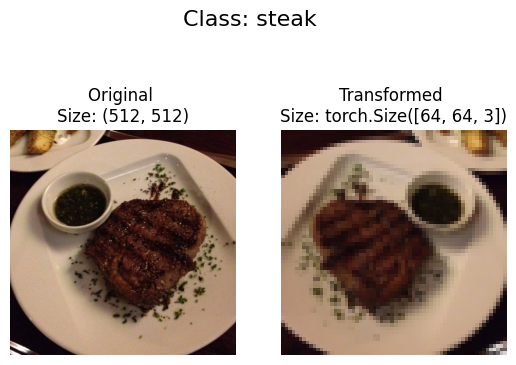

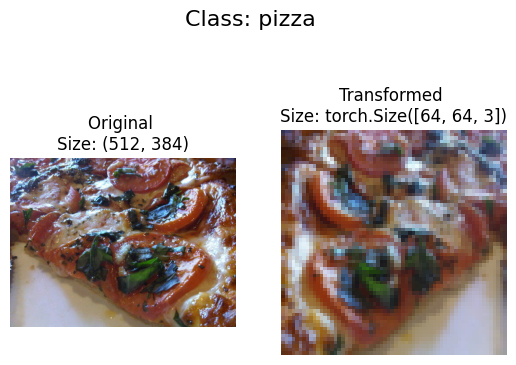

In [13]:
def plot_transformed_images(image_paths, transform, n=3 , seed = 42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### 4. Option 1: Loading Image Data Using ImageFolder

Test out the  data folders with `train_dir` and `test_dir`  and passing in `transform=data_transform` to turn our images into tensors.

In [14]:
#use imagefolder to create dataset
train_data = datasets.ImageFolder(root = train_dir, #target folder of images
                                  transform = data_transform, #transform to perform on data (images)
                                  target_transform = None)  # transform to perform on labels

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

print (f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [15]:
#class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# class name a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
len(train_data),len(test_data)

(225, 75)

In [18]:
img,label = train_data[0][0],train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


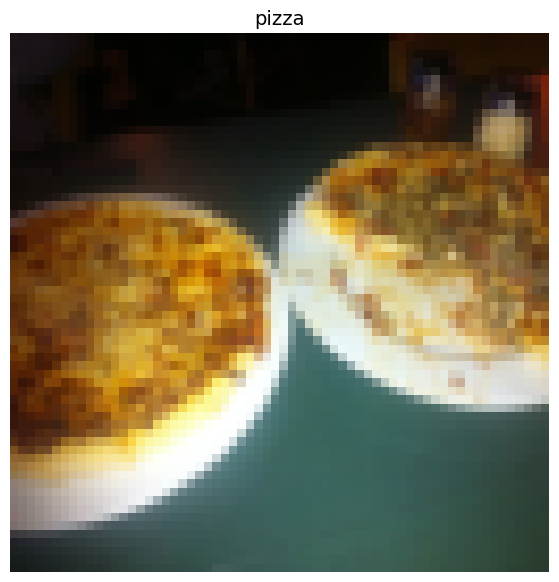

In [19]:
#rearrange the order of dim
img_permute = img.permute(1,2,0)

#print out diff shapes (before and adter)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## 4. Option 1: Loading Image Data Using ImageFolder

Turning Dataset's into DataLoader's makes it iterable so a model can go through learn the relationships between samples and targets (features and labels).

`num_workers` - It defines how many subprocesses will be created to load your data. the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

In [20]:
#turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data,
                             batch_size = 1, # samples per batch
                             num_workers = 1, # subprocesses used for data loading
                             shuffle = True) #shuffle data

test_dataloader = DataLoader(dataset= test_data,
                             batch_size = 1,
                             num_workers= 1,
                             shuffle = False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ba762a37a60>,
 <torch.utils.data.dataloader.DataLoader at 0x7ba762a36170>)

In [21]:
#checking shape
img,label = next (iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


###5. Option 2: Loading Image Data with a Custom Dataset

Building own dataset




*   Python's `os` for dealing with directories ( data is stored in directories).
*   Python' `pathlib` for dealing with filepaths (each images has a unique filepath).
*   `torch` for all things PyTorch.
*   PIL's `Image` class for loading images.
*   `torch.utils.data.Dataset` to subclass and create  own custom Dataset.
*   `torchvision.transforms` to turn images into tensors.
*  arious types from Python's `typing` module to add type hints to  code.







In [22]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [23]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [25]:
#setup path for target directory
target_directory = train_dir
print(f"Target Directory: {target_directory}")

#class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")


Target Directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [26]:
#function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
   # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [27]:
find_classes(train_dir)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder



1. Subclass `torch.utils.data.Dataset`.
2. Initialize  subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform  data if needed).
3. Create several attributes for `paths` (the paths of  target images), `transform` (the transforms we might like to use, this can be `None`), `classes`  and `class_to_idx` (from  `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or `torchvision.io` (for input/output of vision data).
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.


In [33]:
from torch.utils.data import Dataset

#1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  #2.Initialize with a targ_dir and transform (optional) parameter
  def __init__(self,targ_dir: str, transform = None) -> None:

    #3. Create class attributes
    #get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #setup transforms
    self.transform = transform
    #create classes and classes_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  #4. make function to load image
  def load_image(self,index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  #5. overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset
  def __len__(self) -> int:
    return len(self.paths)

  #6. overwrite the __getitem__() method
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.names # expects path in data_folder/class_name/image.jpeg
    class_idx = self.class_to_idx[class_name]

    if self.transform:
        return self.transform(img), class_idx # return data, label (X, y)
    else:
        return img, class_idx # return data, label (X, y)

In [36]:
#augment train data
train_transforms = transforms.Compose({
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
})

#don't augment train data, only reshape
test_transforms = transforms.Compose({
    transforms.Resize((64,64)),
    transforms.ToTensor()
})

In [37]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom


(<__main__.ImageFolderCustom at 0x7ba757af63e0>,
 <__main__.ImageFolderCustom at 0x7ba757af5690>)

In [38]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [39]:
train_data_custom.classes



['pizza', 'steak', 'sushi']

In [40]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [41]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as `classes `(the names of our target classes), the number of images to display (`n`) and a random seed.
2. To prevent the display getting out of hand, cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set).
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. oop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.
